In [45]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# Clean up data

In [74]:
csv_fns = glob(os.path.join('data', 'raw', '*.csv'))

bad_counts_per_var = []

overall_bad_count = 0
overall_good_count = 0

for i, fn in enumerate(csv_fns):
    df = pd.read_csv(fn)
    df = df[df['DT'].str.contains(":")]
    df['DT'] = pd.to_datetime(df['DT'])
    bad_count = df[df['bad'] == True]['bad'].count()
    overall_bad_count += bad_count
    good_count = df[df['bad'] == False]['bad'].count()
    overall_good_count += good_count

    # print(f"File {i + 1}: {fn}")
    # print(f"  Good Count: {good_count}")
    # print(f"  Bad Count: {bad_count}")
    # print()

    bad_counts = df[df['bad'] == True].groupby('var').size()  # Number of bad values per variable
    bad_counts_per_var.append(bad_counts)

    # if i % 2 == 0:
    #     # if even then take FIRST 4 years as held out test data
    #     test_df = df[df['DT'].dt.year <= 1996]
    #     train_df = df[df['DT'].dt.year > 1996]
    # else:
    #     # if odd take the LAST 4 years as training data
    #     test_df = df[df['DT'].dt.year >= 2018]
    #     train_df = df[df['DT'].dt.year < 2018]

    # assert (df.shape[0] == test_df.shape[0] + train_df.shape[0])

    
    # test_fn = os.path.join('data', 'test', f'test_{os.path.basename(fn)}')
    # test_df.to_csv(test_fn, index=False)
    # train_fn = os.path.join('data', 'train', f'train_{os.path.basename(fn)}')
    # train_df.to_csv(train_fn, index=False)

    # plt.plot(df['DT'], df['bad'])
    # plt.show()
    
    # display(df)

print(f'Bad count {overall_bad_count}, good count {overall_good_count}')

bad_counts_df = pd.concat(bad_counts_per_var, axis=1).fillna(0).astype(int)
bad_counts_df.columns = [os.path.basename(fn).replace('.csv', '') for fn in csv_fns]

bad_counts_df['Total'] = bad_counts_df.sum(axis=1)

print("\nOverall Bad Counts per Variable:")
display(bad_counts_df)

Bad count 82665, good count 3766465

Overall Bad Counts per Variable:


,sta119,sta151,sta152,sta161,Total
var,,,,,
RF,15272,2000,15,2,17289
RH_1,1934,6233,2499,14347,25013
SWup,5149,5261,4786,40,15236
Tair_1,959,7371,5852,10945,25127


# explore dataset

# Load data for site wise (leave-one-out) models
For this we just 

In [53]:
# df_list = [
#     pd.read_csv(r'https://raw.githubusercontent.com/jnicolow/anomaly_detection/refs/heads/main/data/raw/sta119.csv'),
#     pd.read_csv(r'https://raw.githubusercontent.com/jnicolow/anomaly_detection/refs/heads/main/data/raw/sta151.csv'),
#     pd.read_csv(r'https://raw.githubusercontent.com/jnicolow/anomaly_detection/refs/heads/main/data/raw/sta152.csv'),
#     pd.read_csv(r'https://raw.githubusercontent.com/jnicolow/anomaly_detection/refs/heads/main/data/raw/sta161.csv')
# ]

df_list = [
    pd.read_csv(os.path.join('data', 'raw', 'sta119.csv')),
    pd.read_csv(os.path.join('data', 'raw', 'sta151.csv')),
    pd.read_csv(os.path.join('data', 'raw', 'sta152.csv')),
    pd.read_csv(os.path.join('data', 'raw', 'sta161.csv'))
]



processed_df_list = []
for df in df_list:
    station_id = df['staID'][0]
    full_len = df.shape[0]
    df = df[df['DT'].str.contains(":")].copy() # remove ones with just the date
    print(f'for station {station_id} {full_len - df.shape[0]} rows with only date')
    df['DT'] = pd.to_datetime(df['DT'])
    # df = df.sort_values('DT')
    processed_df_list.append(df)

df_list = processed_df_list

for station 119 42255 rows with only date
for station 151 42922 rows with only date
for station 152 44835 rows with only date
for station 161 36897 rows with only date


In [54]:
df_list[0]

,staID,DT,value,var,bad
0,119,1990-01-01 01:00:00,137.0000,RF,False
1,119,1990-01-01 01:00:00,94.6200,RH_1,False
2,119,1990-01-01 01:00:00,-0.4651,SWup,False
3,119,1990-01-01 01:00:00,14.6200,Tair_1,False
4,119,1990-01-01 02:00:00,6.0000,RF,False
...,...,...,...,...,...
1024125,119,2021-09-10 08:00:00,17.5100,Tair_1,False
1024126,119,2021-09-10 09:00:00,0.0000,RF,False
1024127,119,2021-09-10 09:00:00,64.4400,RH_1,False
1024128,119,2021-09-10 09:00:00,492.7750,SWup,False


In [55]:
for i, test_df in enumerate(df_list):
    train_dfs = df_list[:i] + df_list[i+1:]


# Load data for site-specific models

In [56]:
df['bad'].value_counts()

bad
False    824516
True      25334
Name: count, dtype: int64

In [58]:
df_list[0]

,staID,DT,value,var,bad
0,119,1990-01-01 01:00:00,137.0000,RF,False
1,119,1990-01-01 01:00:00,94.6200,RH_1,False
2,119,1990-01-01 01:00:00,-0.4651,SWup,False
3,119,1990-01-01 01:00:00,14.6200,Tair_1,False
4,119,1990-01-01 02:00:00,6.0000,RF,False
...,...,...,...,...,...
1024125,119,2021-09-10 08:00:00,17.5100,Tair_1,False
1024126,119,2021-09-10 09:00:00,0.0000,RF,False
1024127,119,2021-09-10 09:00:00,64.4400,RH_1,False
1024128,119,2021-09-10 09:00:00,492.7750,SWup,False


In [68]:
df_var['bad'].value_counts()

Series([], Name: count, dtype: int64)

In [69]:
import matplotlib.pyplot as plt
from datetime import timedelta

var_name = 'RH'


df_var = df[df['var'] == var_name].sort_values('DT') # we are only looking at one variable
# df_var = df_var[df_var['DT'].dt.year == 1996]
for dt in df_var[df_var['bad'] == True]['DT']:
    start_time = dt - timedelta(weeks=1)
    end_time = dt + timedelta(weeks=1)

    window_df = df_var[(df_var['DT'] >= start_time) & (df_var['DT'] <= end_time)]


    anomaly_times = window_df[window_df['bad'] == True]['DT'] # get all anomalies in window

    # Plot values
    plt.figure(figsize=(10, 4))
    plt.plot(window_df['DT'], window_df['value'], label='Value')

    # Mark all anomalies with red dashed lines
    for anomaly_dt in anomaly_times:
        plt.axvline(anomaly_dt, color='red', linestyle='--', alpha=0.7)

    plt.title(f"{var_name} - Window around anomaly at {dt}")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [48]:
df_var['bad'].value_counts()

bad
False    215878
True          2
Name: count, dtype: int64

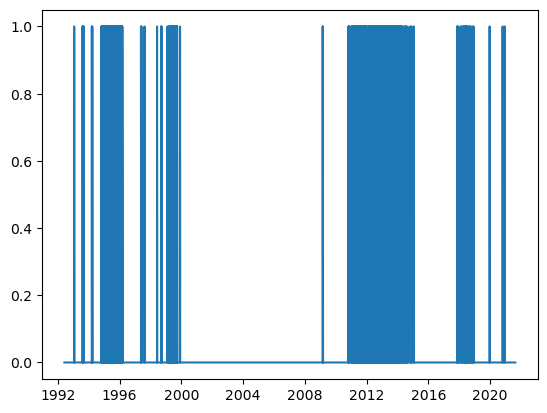

In [38]:
plt.plot(df['DT'], df['bad'])
plt.show()